In [550]:
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings 
warnings.filterwarnings("ignore")


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, accuracy_score


In [551]:
df = pd.read_csv('../data/df.csv',sep = ',')

In [552]:
df.columns

Index(['cd_op', 'MT_CHG_MSL', 'MT_PATRIM_NET', 'EAD_1an_avant_def', 'TX_APPOR',
       'dat_dec_echec', 'ANC_PRO_MAX_PFI', 'arrete', 'MT_EAD_RESID',
       'FL_REL_NON_ANNULE', 'nb_bienHOP', 'cum_frs_externes',
       'dls_mep_entree_def', 'NB_LO_HOP', 'MT_CHA_CSM_REV',
       'CD_DNE_CHR_LGD_SAIN', 'MT_EAD_DNE_CHR_d', 'mt_rev_dispo',
       'MT_REST_VIVRE', 'MR_arr', 'NB_DUR_PFI', 'fl_fonc', 'AMI', 'solution',
       'AGE_EMP1', 'date_entree_defaut', 'NB_CHARGE_HORS_OPE_PFI', 'cum_dec',
       'MT_CHA_IMP', 'max_age_ctx', 'MT_CHA_PIV', 'MT_CHA_PIP', 'TX_ENDET',
       'cum_rec', 'nb_empr_ope', 'PTG', 'MT_PATRIM_MOB', 'fam_PCD',
       'NB_RP_HOP', 'fl_prise_de_gar', 'dls_ges_def', 'nb_prt',
       'mt_dec_cum_IMP_tot', 'fl_prt_Conso', 'niv_gravite_mtf_dfs',
       'DT_MEP_OPE', 'MT_FMG', 'CD_POST_BIEN_PFI', 'MT_CHA_HORS_OPE_PFI',
       'ANC_BANC_MAX_PFI', 'MT_REV_PFI', 'DET', 'Motif', 'Situation_fam',
       'Nature', 'Solution_echec', 'Nature_op', 'MTF', 'ETAT_CIVIL', 'CSP',
       

# Encoding

In [553]:
df['Motif'] = df['Motif'].apply(lambda x : 3 if x == 'Motif tres mauvais' else 2 if x == 'Motif mauvais' else 1)

df['Situation_fam'] = df['Situation_fam'].apply(lambda x : 2 if x == 'Mauvaise situation' else 1)

df['Nature'] = df['Nature'].apply(lambda x : 2 if x == 'Mauvaise nature' else 1)

df['Solution_echec'] = df['Solution_echec'].apply(lambda x : 2 if x == 'Mauvaise solution' else 1)

df['Nature_op'] = df['Nature_op'].apply(lambda x : 2 if x == 'Mauvaise nature' else 1)

df['MTF'] = df['MTF'].apply(lambda x : 2 if x == 'Mauvais MTF' else 1)

df['ETAT_CIVIL'] = df['ETAT_CIVIL'].apply(lambda x : 2 if x == 'Mauvais etat' else 1)

df['CSP'] = df['CSP'].apply(lambda x : 2 if x == 'Mauvaise CSP' else 1)

df['nb_empr_ope'] = df['nb_empr_ope'].apply(lambda x : 1 if x == 'Un emprunteur' else 2)

df = df[['Motif', 'niv_gravite_mtf_dfs', 'MTF',
       'ANC_PRO_MAX_PFI_2', 'nb_empr_ope', 'CD_DNE_CHR_LGD_SAIN', 'MT_EAD_RESID', 'fam_PCD','mt_dec_cum_IMP_tot',
       'cum_dec', 'MT_REST_VIVRE', 'DET', 'arrete', 'cd_op']]


In [554]:
df.drop(columns = 'date_entree_defaut',inplace = True)

In [578]:
df = df[['Motif', 'MT_EAD_DNE_CHR_d', 'MT_EAD_RESID', 'niv_gravite_mtf_dfs',
       'DT_MEP_OPE', 'MTF', 'MT_REV_PFI', 'fam_PCD', 'MT_FMG',
       'ANC_PRO_MAX_PFI', 'EAD_1an_avant_def', 'CD_POST_BIEN_PFI',
       'CD_DNE_CHR_LGD_SAIN', 'max_age_ctx', 'TX_APPOR','DET', 'arrete', 'cd_op']]


In [579]:
df['arrete'] = pd.to_datetime(df['arrete'])

In [594]:
df_validation = df[df['arrete']>"2021-01-01"]

In [605]:
data = df[df['arrete']<"2020-01-02"]

# train test 

In [606]:
X_train = data.select_dtypes(exclude = 'datetime')
X_train.dropna(inplace = True)
X_train.drop(columns = ['cd_op','DET'], inplace = True)

X_test = df_validation.select_dtypes(exclude = 'datetime')
X_test.dropna(inplace = True)
X_test.drop(columns = ['cd_op','DET'], inplace = True)


y_train = data['DET']
y_test = df_validation['DET']

# Optimisation hyper parametres

In [611]:
import optuna
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# Assume X_train, X_test, y_train, y_test are defined

def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': trial.suggest_int('max_depth',4, 20),
        'eta': trial.suggest_loguniform('eta', 0.05, 0.4),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.3, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 75, 100),
        'alpha': trial.suggest_loguniform('alpha', 0.05, 1.0)
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    roc_auc = roc_auc_score(y_test, y_prob)
    return roc_auc

# Create an Optuna study object and perform the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

# Display the optimization results
print(f"Best parameters: {study.best_params}")
print(f"Best AUC score: {study.best_value}")


[I 2024-02-07 20:35:13,959] A new study created in memory with name: no-name-1ba6458e-8055-4e99-a939-a53c2dc22ffe
[I 2024-02-07 20:35:14,833] Trial 0 finished with value: 0.7560773461382767 and parameters: {'max_depth': 12, 'eta': 0.15056450030222793, 'gamma': 0.1425620601938438, 'colsample_bytree': 0.49368256810812194, 'subsample': 0.7567431398006099, 'n_estimators': 83, 'alpha': 0.929201116440922}. Best is trial 0 with value: 0.7560773461382767.
[I 2024-02-07 20:35:15,015] Trial 1 finished with value: 0.7706698981467265 and parameters: {'max_depth': 5, 'eta': 0.1801173583642526, 'gamma': 2.214664151897459e-06, 'colsample_bytree': 0.7107851926470714, 'subsample': 0.7816443395107057, 'n_estimators': 95, 'alpha': 0.16627693096458482}. Best is trial 1 with value: 0.7706698981467265.
[I 2024-02-07 20:35:15,627] Trial 2 finished with value: 0.7615799064289934 and parameters: {'max_depth': 11, 'eta': 0.11199949305662293, 'gamma': 0.21082992034602455, 'colsample_bytree': 0.4196967066105206, 

Best parameters: {'max_depth': 5, 'eta': 0.35080485822822033, 'gamma': 9.478968059699342e-06, 'colsample_bytree': 0.9375956199748232, 'subsample': 0.9792689557211798, 'n_estimators': 94, 'alpha': 0.7180926091895901}
Best AUC score: 0.8008184554967731


Variables utilisées pour l'AUC à 0.8 : ['Motif', 'MT_EAD_DNE_CHR_d', 'MT_EAD_RESID', 'niv_gravite_mtf_dfs',
       'DT_MEP_OPE', 'MTF', 'MT_REV_PFI', 'fam_PCD', 'MT_FMG',
       'ANC_PRO_MAX_PFI', 'EAD_1an_avant_def', 'CD_POST_BIEN_PFI',
       'CD_DNE_CHR_LGD_SAIN', 'max_age_ctx', 'TX_APPOR']

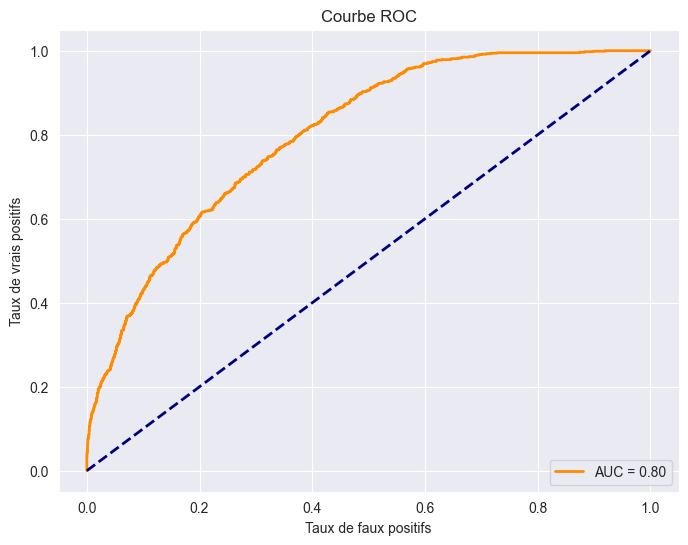

In [612]:
import xgboost as xgb
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


params = {'max_depth': 5, 'eta': 0.35080485822822033, 'gamma': 9.478968059699342e-06, 'colsample_bytree': 0.9375956199748232, 'subsample': 0.9792689557211798, 'n_estimators': 94, 'alpha': 0.7180926091895901}
# Créer le modèle avec les hyperparamètres spécifiés
model = xgb.XGBClassifier(**params)

# Entraîner le modèle
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_prob = model.predict_proba(X_test)[:, 1]

# Calculer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Afficher la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

In [613]:
roc_auc

0.8008184554967731

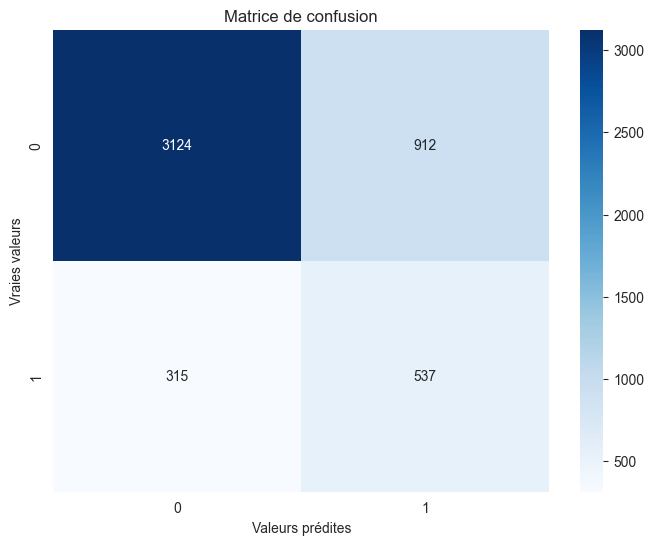

In [614]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Afficher la matrice de confusion sous forme de heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Valeurs prédites')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de confusion')
plt.show()


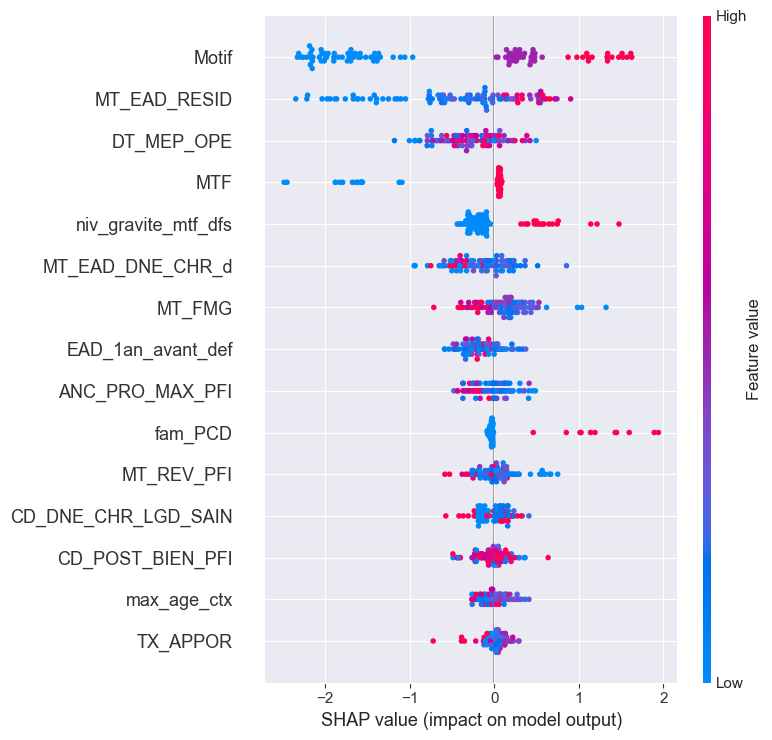

In [615]:
import shap


explainer = shap.TreeExplainer(model)

# Calculer les Shapley values pour un échantillon de données (par exemple, les 100 premières observations)
shap_values = explainer.shap_values(X_train.iloc[:100, :])

# Afficher les Shapley values pour la première observation
shap.summary_plot(shap_values, X_train.iloc[:100, :])

# Si vous voulez expliquer une prédiction spécifique pour une observation donnée, utilisez la fonction shap_values
# par exemple, pour expliquer la prédiction pour la première observation :
shap_values_single = explainer.shap_values(X_train.iloc[[0]])
shap.force_plot(explainer.expected_value, shap_values_single, X_train.iloc[[0]])

In [616]:
shap_values_avg = np.abs(shap_values).mean(axis=0)
top_variables_indices = np.argsort(shap_values_avg)[::-1]


n_top_variables = 15
top_variables = X_train.columns[top_variables_indices[:n_top_variables]]

top_variables

Index(['Motif', 'MT_EAD_RESID', 'DT_MEP_OPE', 'MTF', 'niv_gravite_mtf_dfs',
       'MT_EAD_DNE_CHR_d', 'MT_FMG', 'EAD_1an_avant_def', 'ANC_PRO_MAX_PFI',
       'fam_PCD', 'MT_REV_PFI', 'CD_DNE_CHR_LGD_SAIN', 'CD_POST_BIEN_PFI',
       'max_age_ctx', 'TX_APPOR'],
      dtype='object')